In [1]:
import pickle

# Load meta dict

with open('../../PNC/AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
# Load rest subject ids and splits

with open('../../Work/Abstract/PaperBin/AllThreeSplit.bin', 'rb') as f:
    splits = pickle.load(f)
    subids = splits['allThreeYesWrat']
    groups = splits['groups']
    
print(len(subids))

593


In [2]:
import numpy as np

subidsNp = np.array(subids)

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

rest_ts = [loadSeries('../../PNC', 'rest', meta[subid]['rest']) for subid in subidsNp]
nback_ts = [loadSeries('../../PNC', 'nback', meta[subid]['nback']) for subid in subidsNp]
emoid_ts = [loadSeries('../../PNC', 'emoid', meta[subid]['emoid']) for subid in subidsNp]

print('Loading complete')

Loading complete


In [3]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(rest_ts)
normalizeSubjects(nback_ts)
normalizeSubjects(emoid_ts)

print('Complete')

Complete


In [4]:
# Calculate pearson matrices

rest_p = np.stack([np.corrcoef(sub) for sub in rest_ts])
nback_p = np.stack([np.corrcoef(sub) for sub in nback_ts])
emoid_p = np.stack([np.corrcoef(sub) for sub in emoid_ts])

print(rest_p.shape)
print('Complete')

(593, 264, 264)
Complete


In [5]:
# Create feature vectors (right now just ages, maleness, and femaless)

males = 0
females = 0

X_all = []
for subid in subidsNp:
    subj = meta[subid]
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_all.append(feat)
    if maleness == 1:
        males += 1
    if femaleness == 1:
        females += 1
X_all = np.vstack(X_all)

print(f'{males} {females}')
print(X_all[10:20])
print('Complete')

271 322
[[223   1   0]
 [190   0   1]
 [197   0   1]
 [145   1   0]
 [148   0   1]
 [142   0   1]
 [123   1   0]
 [176   1   0]
 [129   0   1]
 [173   1   0]]
Complete


In [6]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

rest_p_t = convertTorch(rest_p)
nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(rest_p_t.shape)
print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([593, 34716])
torch.Size([593, 34716])
torch.Size([593, 34716])
Complete


In [7]:
wratDict = dict()

with open('../../PNC/wrat.csv', 'r') as f:
    lines = f.readlines()[1:]
    for line in lines:
        line = line.strip().split(',')
        wratDict[line[0]] = {'raw': line[2], 'std': line[3]}

wrat = []

for key in subids:
    wrat.append(float(wratDict[str(key)]['std']))
    
wrat = np.array(wrat)
wrat_t = torch.from_numpy(wrat).float().cuda()

print('Complete')

Complete


In [74]:
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn.dense import DenseGraphConv

class GCN(nn.Module):
    def __init__(self, w, nPara, nPoly, nTgts, dp=0.5):
        super(GCN, self).__init__()
        self.gcn0 = DenseGraphConv(nPara*nPoly*arith(263),w).float().cuda()
        self.gcnAge = DenseGraphConv(w,1).float().cuda()
        self.gcnGen = DenseGraphConv(w,2).float().cuda()
        self.gcnWrt = DenseGraphConv(w,1).float().cuda()
        self.dp = nn.Dropout(p=0.5)
        
    def forward(self, x, **kwargs):
        e = torch.ones(2*[x.shape[0]]).float().cuda()/x.shape[0]
        e = mask(e)
        x = x.reshape(x.shape[0],-1)
        x = self.dp(x)
        x = F.relu(self.gcn0(x,e)).squeeze()
        age = self.gcnAge(x,e).squeeze(0)
        gen = self.gcnGen(x,e).squeeze(0)
        wrt = self.gcnWrt(x,e).squeeze(0)
        tab = {'age': age, 'gender': gen, 'wrat': wrt}
        res = [tab[key] for key in kwargs]
        return res[0] if len(res) == 1 else res
    
class MLP(nn.Module):
    def __init__(self, w, nPara, nPoly, nTgts, dp=0.5):
        super(MLP, self).__init__()
        self.gcn0 = nn.Linear(nPara*nPoly*arith(263),w).float().cuda()
        self.gcnAge = nn.Linear(w,1).float().cuda()
        self.gcnGen = nn.Linear(w,2).float().cuda()
        self.gcnWrt = nn.Linear(w,1).float().cuda()
        self.dp = nn.Dropout(p=0.5)
        
    def forward(self, x, **kwargs):
        x = x.reshape(x.shape[0],-1)
        x = self.dp(x)
        x = F.relu(self.gcn0(x)).squeeze()
        age = self.gcnAge(x)
        gen = self.gcnGen(x)
        wrt = self.gcnWrt(x)
        tab = {'age': age, 'gender': gen, 'wrat': wrt}
        res = [tab[key] for key in kwargs]
        return res[0] if len(res) == 1 else res
        
print('Complete')

Complete


In [177]:
class MiniPgi(nn.Module):
    def __init__(self, w, nPara, nPoly, nTgts, dp=0.5):
        super(MiniPgi, self).__init__()
        self.masks = [nn.Parameter(
            0.01*torch.ones(nPara,nPoly,arith(263),w).float().cuda()
            +0.001*torch.randn(nPara,nPoly,arith(263),w).float().cuda()
        )]
        self.biases = [nn.Parameter(
            0.01*torch.ones(nPara,nPoly,arith(263)).float().cuda()
            +0.001*torch.randn(nPara,nPoly,arith(263)).float().cuda()
        )]
        self.masks.append(nn.Parameter(self.masks[0].clone().detach()))
        self.biases.append(nn.Parameter(self.biases[0].clone().detach()))
        self.dp = nn.Dropout(p=dp)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.2)
        
    def forward(self, x, age=None, gender=None, wrat=None):
        x = self.dp(x)
#         y = x #+ self.biases[0].unsqueeze(0)
#         y = x@self.masks[0].reshape(x.shape[1],-1) #mul(y, self.masks[0])
#         z = x #+ self.biases[0].unsqueeze(0)
#         z = x@self.masks[0].reshape(x.shape[1],-1) #mul(z, self.masks[0])
        y = torch.einsum('abcd,bcde->ae',x,self.masks[0])
        e = y@y.T #torch.einsum('abcd,ebcd->ae', y, z)
        idcs = torch.logical_not(torch.any(age, dim=1))
        e[:,idcs] = 0
        e = self.leakyrelu(mask(e))
        s = torch.sum(e, dim=1)
        e = e/s.unsqueeze(1)
        r = e@age
        return [r, gender, wrat]
        
print('Complete')

Complete


In [178]:
import torch.nn as nn
import torch.nn.functional as F

def makePoly(ps):
    pps = []
    for i in range(ps.shape[0]):
        p = ps[i].flatten()
        pp = nPoly*[None]
        for j in range(nPoly):
            pp[j] = p**(j+1)
        pps.append(torch.stack(pp))
    return torch.stack(pps)

def arith(n):
    return int(n*(n+1)/2)

def mask(e):
    return e - torch.diag(torch.diag(e))

def mul(a, b):
    return torch.einsum('abcd,ecdh->abeh', a, b)

class MultiPgi(nn.Module):
    def __init__(self, w, nPara, nPoly, nTgts, dp=0.5):
        super(MultiPgi, self).__init__()
        self.masks = [nn.Parameter(
                0.01*torch.ones(nPara,nPoly,arith(263),w).float().cuda()
                +0.001*torch.randn(nPara,nPoly,arith(263),w).float().cuda()
            )]
        self.biases = [nn.Parameter(
                0.01*torch.ones(nPara,nPoly,arith(263)).float().cuda()
                +0.001*torch.randn(nPara,nPoly,arith(263)).float().cuda()
            )]
        self.dp = nn.Dropout(p=dp)
        
    def forward(self, x, age=None, gender=None, wrat=None):
        lbls = [age, gender, wrat]
        res = []
        x = self.dp(x)
        for i,lbl in enumerate(lbls):
            if lbl == None:
                continue
            if len(self.masks) == 1:
                idx = 0
            else:
                idx = i+1
                self.biases[0].requires_grad_(False)
#                 self.masks[0].requires_grad_(False)
            y = x #+ self.biases[0].unsqueeze(0)
            y = mul(torch.ones(x.shape).float().cuda()/100, self.masks[0])
            z = x #+ self.biases[idx].unsqueeze(0)
            z = mul(z, self.masks[idx])
            e = torch.einsum('abcd,ebcd->ae', y, z)
            idcs = torch.logical_not(torch.any(lbl, dim=1))
            e[:,idcs] = 0
            e = mask(e)
            s = torch.abs(torch.sum(e, dim=1))
            e /= s.unsqueeze(1)
            r = e@lbl
            res.append(r)
        return res[0] if len(res) == 1 else res
    
    def expandParams(self, optim):
        for i in range(3):
            self.masks.append(nn.Parameter(self.masks[0].clone().detach()))
            self.biases.append(nn.Parameter(self.biases[0].clone().detach()))
            optim.add_param_group({'params': [self.masks[-1], self.biases[-1]]})

def resetWeights(m):
    with torch.no_grad():
        if hasattr(m, 'gw'):
            m.gw += 0.001*torch.randn(m.gw.shape).float().cuda()
            m.bias += 0.001*torch.randn(m.bias.shape).float().cuda()
            m.mask += 0.001*torch.randn(m.mask.shape).float().cuda()
    
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 2500
pPeriod = 100
saveThreshInit = torch.Tensor((150,3e-1,150)).float().cuda()
thresh = torch.Tensor((50,1e-1,50)).float().cuda() # 60,1.5e-1,60
lossScale = torch.Tensor([1,1000,1]).float().cuda() # 1,1000,1
cPeriod = 50
prevLoss = 0
resetThresh = 1e-4
savePath = f'../../Work/PGIGCN2/ModelSav.pyt'

nPoly = 1
para = [makePoly(rest_p_t), makePoly(nback_p_t), makePoly(emoid_p_t)]
    
rmse = []

for i in range(10):
    pgigcn = MiniPgi(2, len(para), nPoly, 3, 0.5)
    optim = torch.optim.Adam(pgigcn.masks + pgigcn.biases, lr=1e-4, weight_decay=1e-4) # 2e-5 2e-5
#     optim = torch.optim.Adam(pgigcn.parameters(), lr=1e-3, weight_decay=0)

    trainIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    X = torch.stack(para, dim=1)
    X = X[trainIdcs]
    Y = torch.from_numpy(X_all[trainIdcs]).float().cuda()
    
    gen = Y[:,1:]
    wrt = wrat_t[trainIdcs].unsqueeze(1)
    age = Y[:,0].unsqueeze(1)
    
    saveThresh = saveThreshInit
    haveSaved = False
    lower0 = False
    lower1 = False

#     pgigcn.expandParams(optim)
    for epoch in range(nEpochs):
        optim.zero_grad()
        res = pgigcn(X, age=age, gender=gen, wrat=wrt)
        loss0 = mseLoss(res[0], age)
        loss1 = ceLoss(res[1], gen)
        loss2 = mseLoss(res[2], wrt)
        loss = torch.stack([loss0, loss1, loss2])
        torch.sum(loss).backward()
#         totLoss = torch.sum(loss*lossScale).detach()
#         torch.sum(lossScale*loss/totLoss).backward()
        optim.step()
        if torch.all(loss < thresh):
            print(f'Early stopping {epoch}')
            break
        if torch.all(loss < saveThresh):
            print(f'Saving {epoch}..... loss={(float(loss0), float(loss1), float(loss2))}')
            saveThresh = loss.detach()
            torch.save(pgigcn.state_dict(), savePath)
            if not haveSaved:
                pgigcn.expandParams(optim)
                optim.lr = 1e-7
            haveSaved = True
        if haveSaved and loss0 > 1000:
            print('Collapsed')
            break
        if (epoch % pPeriod == 0 or epoch == nEpochs-1):
            print(f'epoch {epoch} loss={(float(loss0), float(loss1), float(loss2))}')
#             print(pgigcn.mask[0,0,0,:])
#         if torch.all(loss < torch.Tensor([100,4e-1,100]).float().cuda()) and not lower0:
#             optim.lr = 5e-7
#             lower0 = True
#             print('Lower 0')
#         if torch.all(loss < torch.Tensor([80,2e-1,80]).float().cuda()) and not lower1:
#             optim.lr = 1e-7
#             lower1 = True
#             print('Lower 1')

    print('Finished training')
    
#     pgigcn.load_state_dict(torch.load(savePath))
    pgigcn.eval()
    
    X = torch.stack(para, dim=1)
    Y = torch.from_numpy(X_all).float().cuda()
        
    gen = Y[:,1:]
    wrt = wrat_t.unsqueeze(1)
    age = Y[:,0].unsqueeze(1)

    gen0 = gen.clone().detach()
    gen0[testIdcs] = 0
    wrt0 = wrt.clone().detach()
    wrt0[testIdcs] = 0
    age0 = age.clone().detach()
    age0[testIdcs] = 0
    
    res = pgigcn(X, age=age0, gender=gen0, wrat=wrt0)
    loss0 = mseLoss(res[0][testIdcs].detach(), age[testIdcs]).cpu().numpy()**0.5
    frac1 = torch.sum(torch.argmax(res[1].detach(), dim=1)[testIdcs] 
                     == torch.argmax(gen[testIdcs], dim=1))/testIdcs.shape[0]
    loss2 = mseLoss(res[2][testIdcs].detach(), wrt[testIdcs]).cpu().numpy()**0.5
    
    rmse.append((float(loss0), float(frac1), float(loss2)))
    print(i, end=' ')
    print(rmse[-1])

epoch 0 loss=(1590.3887939453125, 0.3132617473602295, 0.0)
epoch 100 loss=(1575.8189697265625, 0.3132617473602295, 0.0)
epoch 200 loss=(1568.2244873046875, 0.3132617473602295, 0.0)
epoch 300 loss=(1067.3956298828125, 0.3132617473602295, 0.0)
epoch 400 loss=(324.5694580078125, 0.3132617473602295, 0.0)
epoch 500 loss=(82.70178985595703, 0.3132617473602295, 0.0)
epoch 600 loss=(31.94035530090332, 0.3132617473602295, 0.0)
epoch 700 loss=(21.488737106323242, 0.3132617473602295, 0.0)
epoch 800 loss=(19.709882736206055, 0.3132617473602295, 0.0)
epoch 900 loss=(16.56216812133789, 0.3132617473602295, 0.0)
epoch 1000 loss=(15.02721881866455, 0.3132617473602295, 0.0)
epoch 1100 loss=(13.180206298828125, 0.3132617473602295, 0.0)
epoch 1200 loss=(13.363118171691895, 0.3132617473602295, 0.0)
epoch 1300 loss=(14.678018569946289, 0.3132617473602295, 0.0)
epoch 1400 loss=(11.183656692504883, 0.3132617473602295, 0.0)
epoch 1500 loss=(13.68175983428955, 0.3132617473602295, 0.0)
epoch 1600 loss=(11.855684

epoch 2499 loss=(12.037141799926758, 0.3132617473602295, 0.0)
Finished training
4 (24.709611892700195, 0.5932203531265259, 105.55526733398438)
epoch 0 loss=(1540.5526123046875, 0.3132617473602295, 0.0)
epoch 100 loss=(1526.4915771484375, 0.3132617473602295, 0.0)
epoch 200 loss=(1519.0770263671875, 0.3132617473602295, 0.0)
epoch 300 loss=(991.7460327148438, 0.3132617473602295, 0.0)
epoch 400 loss=(356.8243713378906, 0.3132617473602295, 0.0)
epoch 500 loss=(81.13492584228516, 0.3132617473602295, 0.0)
epoch 600 loss=(32.78477478027344, 0.3132617473602295, 0.0)
epoch 700 loss=(18.33203125, 0.3132617473602295, 0.0)
epoch 800 loss=(17.344667434692383, 0.3132617473602295, 0.0)
epoch 900 loss=(16.405437469482422, 0.3132617473602295, 0.0)
epoch 1000 loss=(14.031926155090332, 0.3132617473602295, 0.0)
epoch 1100 loss=(12.294692039489746, 0.3132617473602295, 0.0)
epoch 1200 loss=(11.600244522094727, 0.3132617473602295, 0.0)
epoch 1300 loss=(12.812681198120117, 0.3132617473602295, 0.0)
epoch 1400 l

epoch 2300 loss=(10.285991668701172, 0.3132617473602295, 0.0)
epoch 2400 loss=(12.66905403137207, 0.3132617473602295, 0.0)
epoch 2499 loss=(10.105657577514648, 0.3132617473602295, 0.0)
Finished training
9 (29.102874755859375, 0.4576271176338196, 101.96451568603516)


In [179]:
for a,b,c in rmse:
    print(a)

26.30906867980957
30.75360679626465
21.2341365814209
22.429426193237305
24.709611892700195
23.525463104248047
24.3647518157959
27.66916847229004
26.92913055419922
29.102874755859375


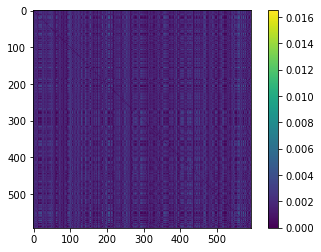

In [155]:
y = X #+ self.biases[0].unsqueeze(0)
y = mul(y, pgigcn.masks[0])
z = X #+ self.biases[0].unsqueeze(0)
z = mul(z, pgigcn.masks[0])
e = torch.einsum('abcd,ebcd->ae', y, z)
idcs = torch.logical_not(torch.any(age0, dim=1))
e[:,idcs] = 0
e = F.relu(mask(e))
s = torch.sum(e, dim=1)
e = e/s.unsqueeze(1)
r = e@age0

# print(e[0])

import matplotlib.pyplot as plt

plt.imshow(e.detach().cpu().numpy())
plt.colorbar()
plt.show()